---
---

<img src="logoP1.png" width=160px align="right"></span>
##### <img src="logoMoSEF.jpeg" width=100px align="right"></span>

# <span style="background-color: "> **_PROJET PYTHON AVANCE_** </span>

 <div style="text-align:right;">Projet réalisé par : Anisoara Ababii, Oussama Laaumari, Camil Zahi</div>
 <div style="text-align:right;">Supervisé par : Hager Oueslati </div>

<div style="text-align:right;"> Janvier 2023 </div>

---
---

In [7]:
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from functools import reduce
import pandas as pd
import time
import re
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

import requests
from datetime import datetime

import asyncio
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from time import sleep, time

import httpx
from concurrent.futures.thread import ThreadPoolExecutor

from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.sql.functions import col

from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument("--headless")

In [1]:
# Pyspark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("Weather.com").getOrCreate()

In [2]:
from datetime import datetime, timedelta

def generate_dates(dates):
    """
    Cette fonction prend en entrée une liste de dates sous la forme de deux chaînes de caractères 'YYYY-MM' (année-mois)
    et génère une liste de tous les mois compris entre ces deux dates.
    """
    # Conversion des chaînes de caractères en objets datetime pour la date de début
    start_date = datetime.strptime(dates[0], '%Y-%m')

    # Conversion des chaînes de caractères en objets datetime pour la date de fin
    end_date = datetime.strptime(dates[1], '%Y-%m')

    # Initialisation de la variable pour stocker la date en cours
    current_month = start_date

    # Initialisation de la liste pour stocker les dates générées
    date_list = []

    # Boucle pour générer les dates jusqu'à ce que la date en cours dépasse la date de fin
    while current_month < end_date:
    
        # Ajout de la date en cours au format 'YYYY-MM' dans la liste de dates
        date_list.append(current_month.strftime('%Y-%m'))

        # Calcul de la date du mois suivant en ajoutant 31 jours à la date en cours
        next_month = current_month + timedelta(days=31)

        # Vérification si le mois suivant est le même que celui de la date en cours
        if next_month.month == current_month.month:

            # Si oui, on enlève les jours excédentaires pour obtenir le dernier jour du mois
            next_month = next_month - timedelta(days=next_month.day)
       
        # Mise à jour de la date en cours pour itérer sur le mois suivant
        current_month = next_month

    # Ajout de la date de fin au format 'YYYY-MM' dans la liste de dates
    date_list.append(end_date.strftime('%Y-%m'))

    # Renvoi de la liste de dates générée
    return date_list

# Exemple d'utilisation de la fonction avec des dates de début et de fin
dates = ['2022-1','2023-1']
print(generate_dates(dates))

['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01']


In [3]:
import multiprocessing
print(f"This machine has {multiprocessing.cpu_count()} CPU cores")

This machine has 8 CPU cores


# Code à lancer pour scrapper les urls et le code source de chaque page

In [28]:
page_lyon = 'https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/'
page_paris = 'https://www.wunderground.com/history/monthly/fr/paris/LFPO/date/'
page_marseille = 'https://www.wunderground.com/history/monthly/fr/marseille/LFML/date/'
page_new_york = "https://www.wunderground.com/history/monthly/us/ny/new-york-city/KLGA/date/"
page_milan = "https://www.wunderground.com/history/monthly/it/milan/LIML/date/"
page_madrid = "https://www.wunderground.com/history/monthly/es/madrid/LEMD/date/"


dates = ['2021-1','2023-1']
urls = []

# Boucle pour générer les URLs en utilisant la fonction generate_dates et en les concaténant à la variable page
for d in generate_dates(dates):
    urls.append(page_lyon+d)

# Création d'un pool de 13 threads pour l'exécution en parallèle et accélérer le processus
executor = ThreadPoolExecutor(13)

# Définition de la fonction scrape qui prend en entrée une URL et un loop asynchrone
def scrape(url, *, loop):

    # Exécution de la fonction scraper_speed dans le thread pool en utilisant le loop asynchrone
    loop.run_in_executor(executor, scraper_speed, url)

# Initialisation de la liste pour stocker les résultats
rr = []

# Définition de la fonction scraper_speed qui prend en entrée une URL
def scraper_speed(url):
    
    # Utilisation du Chromedriver avec les options spécifiées dans le script précédent
    driver = webdriver.Chrome("./chromedriver", options=chrome_options)
    
    # Accès à la page de l'URL    
    driver.get(url)

    # Récupération du code source de la page
    r = driver.page_source

    # Ajout du code source de la page dans la liste de résultats
    rr.append(r)

    # Fermeture du navigateur
    driver.quit()

# Récupération du loop asynchrone courant
loop = asyncio.get_event_loop()

# Boucle pour itérer sur les URLs et les passer à la fonction scrape
for url in urls:
    scrape(url, loop=loop)

# Exécution du loop asynchrone jusqu'à ce que toutes les tâches soient terminées (il y a un message d'erreur "This event loop is already running" mais le code fonctionne bien)
loop.run_until_complete(asyncio.gather(*asyncio.all_tasks(loop)))



C:\Users\Oussama\AppData\Local\Temp\ipykernel_23228\1348923753.py:32: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome("./chromedriver", options=chrome_options)


RuntimeError: This event loop is already running

In [30]:
# Affichage de la longueur de la liste rr (37 correspond à 37 mois)
# Pendant le processus il est possible de regarder la liste se remplir et donc sa taille augmenter
len(rr)

25

---

**<div style="text-align:center;">!!! Attention !!! </div>**

Il faut attendre que le code précédent affiche le nombre de mois souhaité pour la longueur de la liste rr. Sinon attendre et relancer le code précédent jusqu'à ce qu'on arrive à la longueur souhaité. Le nombre devrait monter au fur et à mesure jusqu'à 37 par exemple pour 37 mois.

---

In [31]:
# Initialisation de la liste pour stocker les dates extraites
liste_de_date = []

# Boucle pour itérer sur les résultats de la page
for i in range(len(rr)):
    # Parsing de la source de la page en utilisant BeautifulSoup 
    soup = BS(rr[i], "html.parser")

    # Compilation d'un motif d'expression régulière pour sélectionner les liens correspondants
    pattern = re.compile(page_lyon+r'\d{4}-\d{2}')

    # Recherche des liens correspondant au motif dans la source de la page
    links = soup.find_all('link', href=pattern)
    
    # Ajout des liens trouvés dans la liste de dates
    liste_de_date.append(links)
    

In [32]:
# Récupération du premier lien de la liste de dates pour verifier que cela a fonctionné
liste_de_date[0]

[<link href="https://www.wunderground.com/history/monthly/fr/lyon/LFLL/date/2021-04" rel="canonical"/>]

**On transforme les liens en string pour mieux les manipuler ensuite**

In [33]:
# Initialisation de la liste pour stocker les dates extraites sous forme de chaînes de caractères
dates_str = []

# Boucle pour itérer sur la liste de liens contenant des dates
for links in liste_de_date:
    
    # Boucle pour itérer sur chaque lien contenant une date
    for link in links:
        
        # Récupération de la date dans le lien en utilisant la méthode .get() de l'objet dictionnaire "attrs" de BeautifulSoup
        # et en utilisant .split() pour séparer les différentes parties de l'URL pour récupérer la date
        date = link.attrs.get('href').split('/')[-1]
        
        # Ajout de la date dans la liste de dates
        dates_str.append(date)

In [34]:
len(dates_str)

25

In [12]:
from pyspark.sql.types import *
from pyspark.sql.functions import to_date


# Fonction pour scrapper les pages et créer le dataframe

In [35]:
def scraper(liste_de_lien, jours):
    """
    Cette fonction prend en entrée une liste de lien à scrapper et le paramètre 
    jours pour que la fonction puisse fonctionner si on souhaite récupérer les données jusqu'à 
    aujourd'hui. Le paramètre jours doit être 29 si on est le 29.

    """
    
    output = pd.DataFrame()


    for index, lien in enumerate(liste_de_lien):
        soup = BS(lien, "html.parser")
        container = soup.find('lib-city-history-observation')
        check = container.find('tbody')
        data = []
        
        for c in check.find_all('tr', class_='ng-star-inserted'):
            for i in c.find_all('td', class_='ng-star-inserted'):
                trial = i.text
                trial = trial.strip('  ')
                data.append(trial)
                

        if round(len(data) / 17 - 1) == jours: 
            ecart0 = (jours+1)*3
            Temperature = pd.DataFrame([data[jours+1:(jours+1)+ecart0][x:x + 3] for x in range(0, len(data[jours+1:(jours+1)+ecart0]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            
            Dew_Point = pd.DataFrame([data[(jours+1)+ecart0:(jours+1)+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0:(jours+1)+ecart0+ecart0]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[(jours+1)+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[(jours+1)+ecart0+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0][x:x + 3] for x in range(0, len(data[(jours+1)+ecart0+ecart0+ecart0+ecart0:(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:jours+1][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[(jours+1)+ecart0+ecart0+ecart0+ecart0+ecart0:][1:], columns=['Precipitation'])
                      

        if round(len(data) / 17 - 1) == 31:
            Temperature = pd.DataFrame([data[32:128][x:x + 3] for x in range(0, len(data[32:128]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[128:224][x:x + 3] for x in range(0, len(data[128:224]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[224:320][x:x + 3] for x in range(0, len(data[224:320]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[320:416][x:x + 3] for x in range(0, len(data[320:416]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[416:512][x:x + 3] for x in range(0, len(data[416:512]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:32][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[512:][1:], columns=['Precipitation'])
          
        elif round(len(data) / 17 - 1) == 28:
            Temperature = pd.DataFrame([data[29:116][x:x + 3] for x in range(0, len(data[29:116]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[116:203][x:x + 3] for x in range(0, len(data[116:203]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[203:290][x:x + 3] for x in range(0, len(data[203:290]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[290:377][x:x + 3] for x in range(0, len(data[290:377]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[377:464][x:x + 3] for x in range(0, len(data[377:463]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:29][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[464:][1:], columns=['Precipitation'])
        elif round(len(data) / 17 - 1) == 29:
            Temperature = pd.DataFrame([data[30:120][x:x + 3] for x in range(0, len(data[30:120]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[120:210][x:x + 3] for x in range(0, len(data[120:210]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[210:300][x:x + 3] for x in range(0, len(data[210:300]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[300:390][x:x + 3] for x in range(0, len(data[300:390]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[390:480][x:x + 3] for x in range(0, len(data[390:480]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:30][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[480:][1:], columns=['Precipitation'])

        elif round(len(data) / 17 - 1) == 30:
            Temperature = pd.DataFrame([data[31:124][x:x + 3] for x in range(0, len(data[31:124]), 3)][1:],
                                       columns=['Temp_max', 'Temp_avg', 'Temp_min'])
            Dew_Point = pd.DataFrame([data[124:217][x:x + 3] for x in range(0, len(data[124:217]), 3)][1:],
                                     columns=['Dew_max', 'Dew_avg', 'Dew_min'])
            Humidity = pd.DataFrame([data[217:310][x:x + 3] for x in range(0, len(data[217:310]), 3)][1:],
                                    columns=['Hum_max', 'Hum_avg', 'Hum_min'])
            Wind = pd.DataFrame([data[310:403][x:x + 3] for x in range(0, len(data[310:403]), 3)][1:],
                                columns=['Wind_max', 'Wind_avg', 'Wind_min'])
            Pressure = pd.DataFrame([data[403:496][x:x + 3] for x in range(0, len(data[403:496]), 3)][1:],
                                    columns=['Pres_max', 'Pres_avg', 'Pres_min'])
            Date = pd.DataFrame(data[:31][1:], columns=data[:1])
            Precipitation = pd.DataFrame(data[496:][1:], columns=['Precipitation'])        
        else:

            print('Data not in normal length')

        dfs = [Date, Temperature, Dew_Point, Humidity, Wind, Pressure, Precipitation]

        df_final = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True), dfs)

        df_final['Date'] = str(dates_str[index]) + "-" + df_final.iloc[:, :1].astype(str)

        output = output.append(df_final)

    print('Scraper done!')

    output = output[['Temp_avg', 'Temp_min', 'Dew_max', 'Dew_avg', 'Dew_min', 'Hum_max',
                     'Hum_avg', 'Hum_min', 'Wind_max', 'Wind_avg', 'Wind_min', 'Pres_max',
                     'Pres_avg', 'Pres_min', 'Precipitation', 'Date']]

    return output

In [ ]:
# Appel de la fonction scraper pour récupérer les données à partir de la ressource rr et scraper 26 pages
df_scrap = scraper(rr, 29)

In [37]:
df_scrap.head()

,Temp_avg,Temp_min,Dew_max,Dew_avg,Dew_min,Hum_max,Hum_avg,Hum_min,Wind_max,Wind_avg,Wind_min,Pres_max,Pres_avg,Pres_min,Precipitation,Date
0,64.5,52,41,35.7,28,54,35.6,22,13,7.4,2,29.3,29.2,29.2,0.00,2021-04-1
1,59.6,46,48,39.4,28,66,48.1,31,21,8.7,1,29.2,29.2,29.1,0.00,2021-04-2
2,48.7,41,37,33.7,28,76,57.2,38,28,18.7,12,29.2,29.2,29.1,0.00,2021-04-3
3,47.5,36,32,30.0,28,75,52.9,36,16,6.9,0,29.3,29.2,29.2,0.00,2021-04-4
4,51.5,39,39,33.5,28,70,51.7,34,25,5.9,0,29.2,29.1,29.0,0.00,2021-04-5


In [38]:
# On change le format de la colonne date pour l'utiliser
df_scrap['Date'] =  pd.to_datetime(df_scrap['Date'], format='%Y-%m-%d')

In [39]:
df_scrap = df_scrap.sort_values('Date')

In [40]:
# Création d'un dataframe spark pour faire le feature engineering
df_scrap = spark.createDataFrame(df_scrap)

# Time series

**Feature engineering Pyspark**

In [41]:

df_scrap = df_scrap.withColumn("Temp_avg", col("Temp_avg").cast("float"))


In [42]:
df_scrap = df_scrap.sort("Date")

df_scrap = df_scrap.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("Date")))

In [43]:
train_df = df_scrap.where("rank <= .8").drop("rank")
train_df.count()

607

In [44]:
test_df = df_scrap.where("rank > .8").drop("rank")
test_df.count()

152

In [45]:
train_df = train_df.withColumnRenamed("Date", "index1").drop("Date")
train_df = train_df.selectExpr("*", "index1 as index").drop("index1")

test_df = test_df.withColumnRenamed("Date", "index1").drop("Date")
test_df = test_df.selectExpr("*", "index1 as index").drop("index1")

# Pyspark

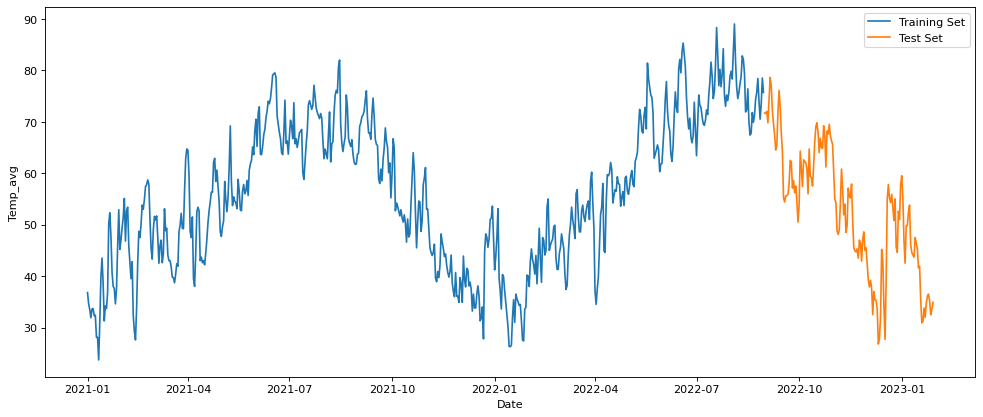

In [46]:
figure(figsize=(15,6),dpi=80)

train_rdd = train_df.select("index", "Temp_avg").rdd.map(lambda row: (row[0], row[1]))
test_rdd = test_df.select("index", "Temp_avg").rdd.map(lambda row: (row[0], row[1]))

# Convertir l'RDD en un tableau numpy
train_arr = np.array(train_rdd.collect())
test_arr = np.array(test_rdd.collect())

# Tracer le graphique
plt.plot(train_arr[:,0], train_arr[:,1], label='Training Set')#, title='Data Train/Test Split')
plt.plot(test_arr[:,0], test_arr[:,1], label='Test Set')#, title='Data Train/Test Split')

plt.xlabel('Date')
plt.ylabel('Temp_avg')
plt.legend()
plt.show()

**Fonction pour créer de nouvelles variables**

In [47]:
from pyspark.sql.functions import dayofweek, quarter, month, year, dayofyear, dayofmonth, weekofyear

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df2 = df.withColumn("dayofweek", dayofweek(df.index)) \
            .withColumn("quarter", quarter(df.index)) \
            .withColumn("month", month(df.index)) \
            .withColumn("year", year(df.index)) \
            .withColumn("dayofyear", dayofyear(df.index)) \
            .withColumn("dayofmonth", dayofmonth(df.index)) \
            .withColumn("weekofyear", weekofyear(df.index))
    return df2


train_df = create_features(train_df)
test_df = create_features(test_df)

In [49]:
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'Temp_avg'

X_train = train_df.select(*FEATURES)
y_train = train_df.select(TARGET)

X_test = test_df.select(*FEATURES)
y_test = test_df.select(TARGET)


In [50]:
# Initialisation du régresseur XGBoost avec des paramètres spécifiques
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=4,
                       learning_rate=0.01)

# Entraînement du modèle              
reg.fit(X_train.toPandas(), y_train.toPandas(),
        eval_set=[(X_train.toPandas(), y_train.toPandas()), (X_test.toPandas(), y_test.toPandas())],
        verbose=100)

[16:41:42] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:57.04355	validation_1-rmse:53.34289
[100]	validation_0-rmse:21.75324	validation_1-rmse:23.09425
[200]	validation_0-rmse:9.30495	validation_1-rmse:13.09807
[300]	validation_0-rmse:5.38599	validation_1-rmse:9.74732
[400]	validation_0-rmse:4.28786	validation_1-rmse:8.90655
[500]	validation_0-rmse:3.95994	validation_1-rmse:8.72250
[596]	validation_0-rmse:3.79647	validation_1-rmse:8.70808


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

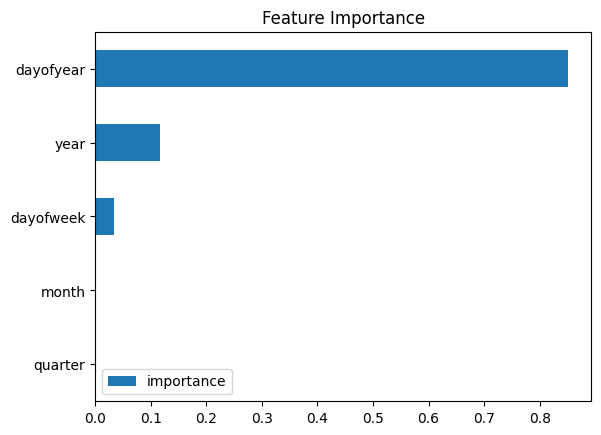

In [51]:
# Importance des features
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
            
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [54]:
test_df

DataFrame[Temp_avg: float, Temp_min: string, Dew_max: string, Dew_avg: string, Dew_min: string, Hum_max: string, Hum_avg: string, Hum_min: string, Wind_max: string, Wind_avg: string, Wind_min: string, Pres_max: string, Pres_avg: string, Pres_min: string, Precipitation: string, index: timestamp, dayofweek: int, quarter: int, month: int, year: int, dayofyear: int, dayofmonth: int, weekofyear: int]

In [58]:
# Ajout de la colonne "prediction" au dataframe "test" avec les prédictions du modèle
pred = reg.predict(X_test.toPandas())

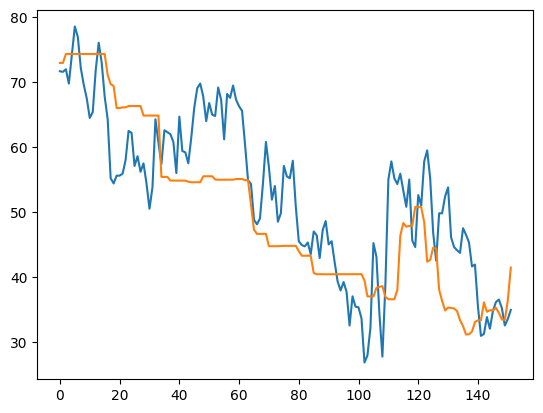

In [59]:
# Graphique permettant de voir si le modèle arrive à faire de bonne prédiction
# On remarque que le modèle à de bons résultats
plt.plot(y_test.toPandas())
plt.plot(pred)
plt.show()

In [62]:
# On fait le choix d'utiliser la métrique MAE car elle est facilement interprétable par rapports aux autres métriques
# les données de températures sont en fahrenheit 
# En moyenne le modèle fait une erreur de 2.43 fahrenheit en valeur absolue
score = np.sqrt(mean_absolute_error(y_test.toPandas(), pred))
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 2.68


In [63]:
# On peut faire une prédiction pour le 29 janvier 2023
# Le modèle prédit 38.5 fahrenheit 
reg.predict(np.array([29, 7, 1, 1, 2023]).reshape(1,5))

array([39.38413], dtype=float32)

In [198]:
# export d'une base de donnée
#df_madrid = df_scrap.copy()
#df_madrid.to_csv('Madrid.csv')

**On verifie à l'aide d'une api la température à Lyon le 29 janvier 2023 et il fait 37.4 fahrenheit donc notre modèle est plutôt précis**

In [64]:
import requests
from datetime import datetime
import time


city = 'Lyon'

api_key = 'f15d6887ef0449fa9f695040232701'

url = f"http://api.weatherapi.com/v1/current.json?key={api_key}&q={city}"
response = requests.get(url)
data = response.json()
data['current']['temp_f']

37.4